# Ejercicio análisis time series

En este ejercicio vamos a trabajar con el histórico de valores en bolsa de una empresa que se dedica a vender muebles. Se pide:

1. Importa los datos 'df_furniture.csv' 
2. Trata la fecha como texto. Crea una columna para el año, mes y día, y a partir de esas columnas crea la de fecha, en formato datetime de pandas
3. ¿De qué fecha a qué fecha va el histórico?
4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?
5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?
6. Parece que hay una tendencia, pero no se aprecia bien con tanto pico en la serie. ¿Conoces algún método para representar mejor la tendencia?
7. Estaría bien visualizar todos los componentes de la serie temporal por separado
8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional
9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuéstralo mediante una matriz de correlación. ¿Esto es bueno para los modelos?
10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?
11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Cargamos los datos

In [37]:
df = pd.read_csv("data/df_furniture.csv")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     326 non-null    object 
 1   furniture_price_adjusted  331 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


In [39]:
min_fecha = df['Month'].dropna().sort_values(ascending=True).iloc[0]
max_fecha = df['Month'].dropna().sort_values(ascending=False).iloc[0]

In [34]:
# min_fecha = df.sort_values(by=['Month'], ascending=True).iloc[0, 0]
# max_fecha = df.sort_values(by=['Month'], ascending=False).iloc[0, 0]

In [33]:
min_fecha

'1992-01-01'

In [40]:
df['Month'] = pd.date_range(min_fecha, max_fecha, freq = 'MS')

In [8]:
df.iloc[14:17]

,Month,furniture_price_adjusted
14,1993-03-01,2449.195623
15,1993-04-01,2457.704334
16,1993-05-01,2552.874950


## 2. Tratar la fecha como texto y parsear

In [41]:
df['date_str'] = df['Month'].astype(str)
df['year'] = df['date_str'].apply(lambda x: int(x[:4]))
df['month'] = df['date_str'].apply(lambda x: int(x[5:7]))
df['day'] = df['date_str'].apply(lambda x: int(x[8:]))
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df_new = df.copy().set_index('date')
df = df.set_index('date')[['furniture_price_adjusted']]
df

,furniture_price_adjusted
date,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618
...,...
2019-03-01,9718.107698
2019-04-01,9248.814254
2019-05-01,10001.305304


## 3. ¿De qué fecha a qué fecha va el histórico?

La serie va desde enero de 1992 a julio de 2019

In [10]:
min(df.index), max(df.index)

(Timestamp('1992-01-01 00:00:00'), Timestamp('2019-07-01 00:00:00'))

## 4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?

Se ve que tiene una clara tendencia al alza, a pesar de una pequeña bajada en als acciones en el 2007.

También apreciamos estacionalidad, al cumplirse cierto patrón a lo largo del tiempo

<AxesSubplot: xlabel='date'>

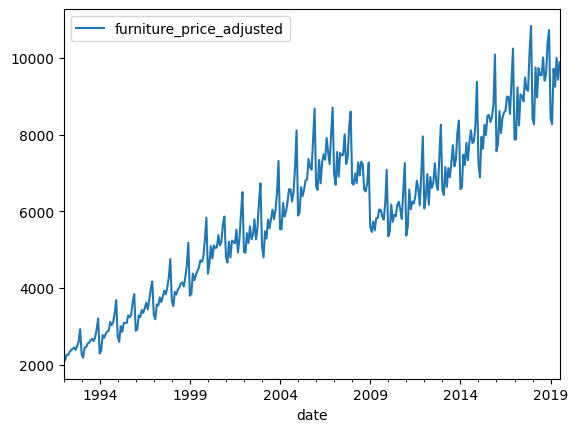

In [11]:
ax = df['furniture_price_adjusted'].plot()
ax = df['furniture_price_adjusted'].plot()
ax.axhline(mean, color='r')
ax.axhline(mean+std, color='g', ls='--') 
ax.axhline(mean-std, color='g', ls='--')
df.plot()

## 5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?

In [12]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['furniture_price_adjusted'].values, autolag = 'AIC')
print('AD_Fuller Method:', result[1])

AD_Fuller Method: 0.7035529748090005


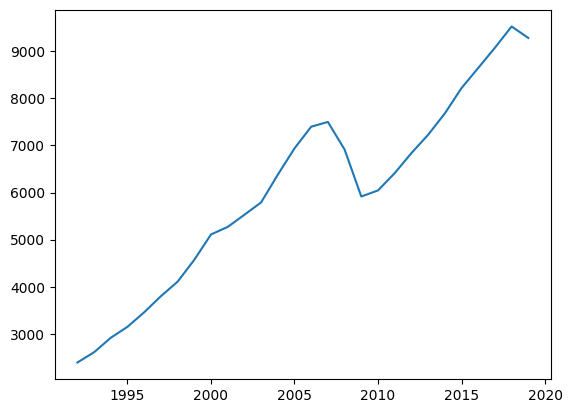

In [13]:
a = df_new.groupby('year')['furniture_price_adjusted'].mean()
plt.plot(a.index, a)

## 6. ¿Conoces algún método para representar mejor la tendencia?

/var/folders/m8/hp9mxxbj6dv9x3px18fy22_r0000gn/T/ipykernel_2631/3858659238.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(years, rotation=45, ha='right')


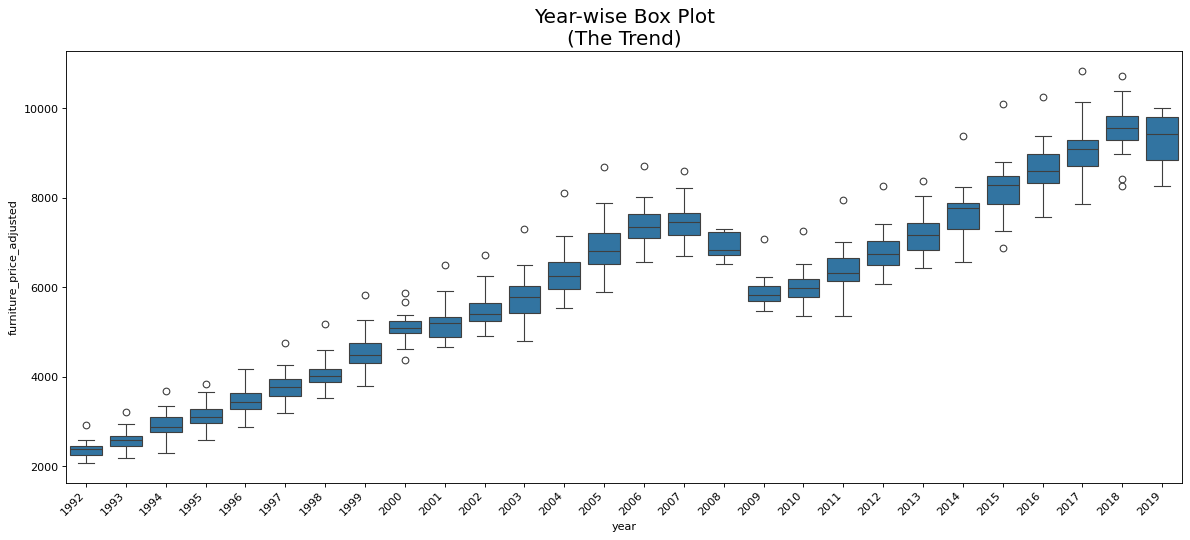

In [14]:
import seaborn as sns

# Preprocesamos:
years = df_new['year'].unique()
# Creamos gráfico de caja para la tendencia (anual) y la estacionalidad (mensual):
fig, axes = plt.subplots(1, 1, figsize=(18,7), dpi= 80)
sns.boxplot(x='year', y='furniture_price_adjusted', data=df_new, ax=axes)
# sns.boxplot(x='month', y='furniture_price_adjusted', data=df_new.loc[~df_new.year.isin([2019]), :])
# Identificamos las gráficas:
axes.set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes.set_xticklabels(years, rotation=45, ha='right')
plt.show()

<AxesSubplot: xlabel='date'>

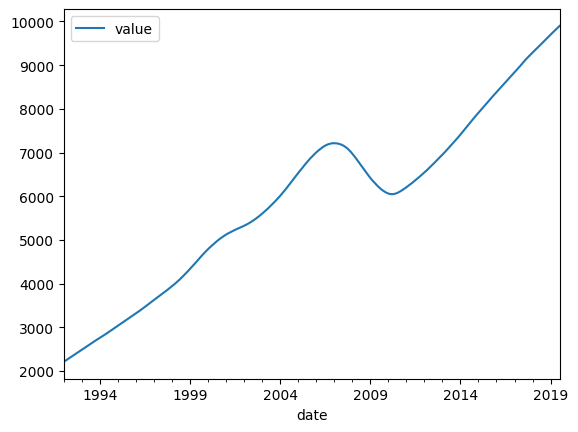

In [15]:
from statsmodels.nonparametric.smoothers_lowess import lowess
df_lowess_15 = pd.DataFrame(lowess(df['furniture_price_adjusted'], 
                                   df.index, 
                                   frac=0.15)[:, 1], 
                            index=df.index, columns=['value'])
df_lowess_15.plot()

## 7. Estaría bien visualizar todos los componentes de la serie temporal por separado

In [16]:
df_new

,Month,furniture_price_adjusted,date_str,year,month,day
date,,,,,,
1992-01-01,1992-01-01,2073.432724,1992-01-01,1992,1,1
1992-02-01,1992-02-01,2114.485812,1992-02-01,1992,2,1
1992-03-01,1992-03-01,2260.570891,1992-03-01,1992,3,1
1992-04-01,1992-04-01,2255.103236,1992-04-01,1992,4,1
1992-05-01,1992-05-01,2331.414618,1992-05-01,1992,5,1
...,...,...,...,...,...,...
2019-03-01,2019-03-01,9718.107698,2019-03-01,2019,3,1
2019-04-01,2019-04-01,9248.814254,2019-04-01,2019,4,1
2019-05-01,2019-05-01,10001.305304,2019-05-01,2019,5,1


In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Modelo aditivo:
result_add = seasonal_decompose(df_new[df_new.columns[1]], model='additive', extrapolate_trend='freq')
# Modelo multiplicativo
result_mul = seasonal_decompose(df_new[df_new.columns[1]], model='multiplicative', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (8,8)})

In [18]:
plt.rcParams.update({'figure.figsize': (8,8)})

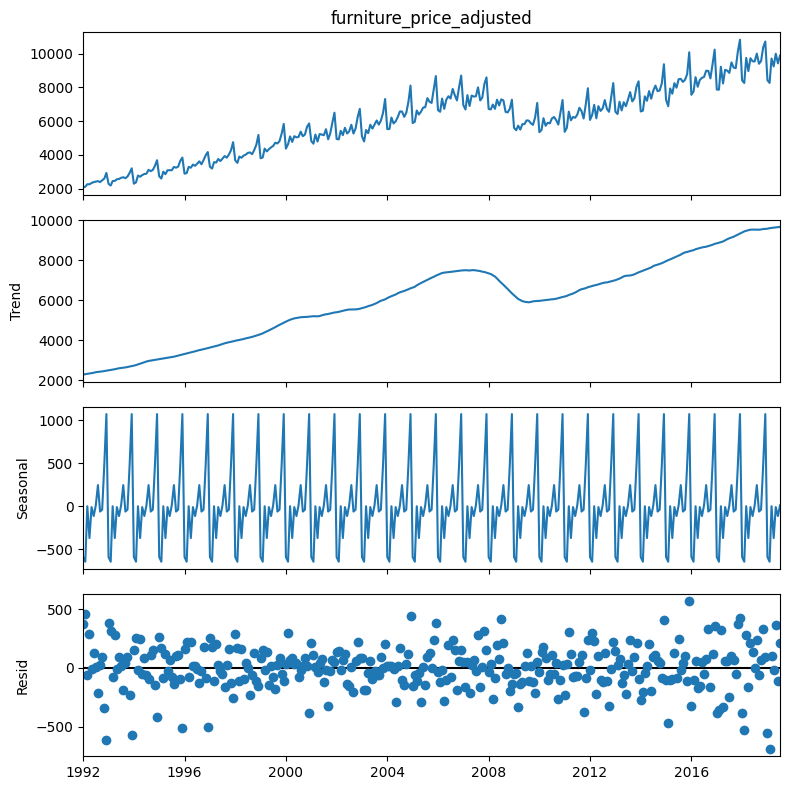

In [19]:
result_add.plot();

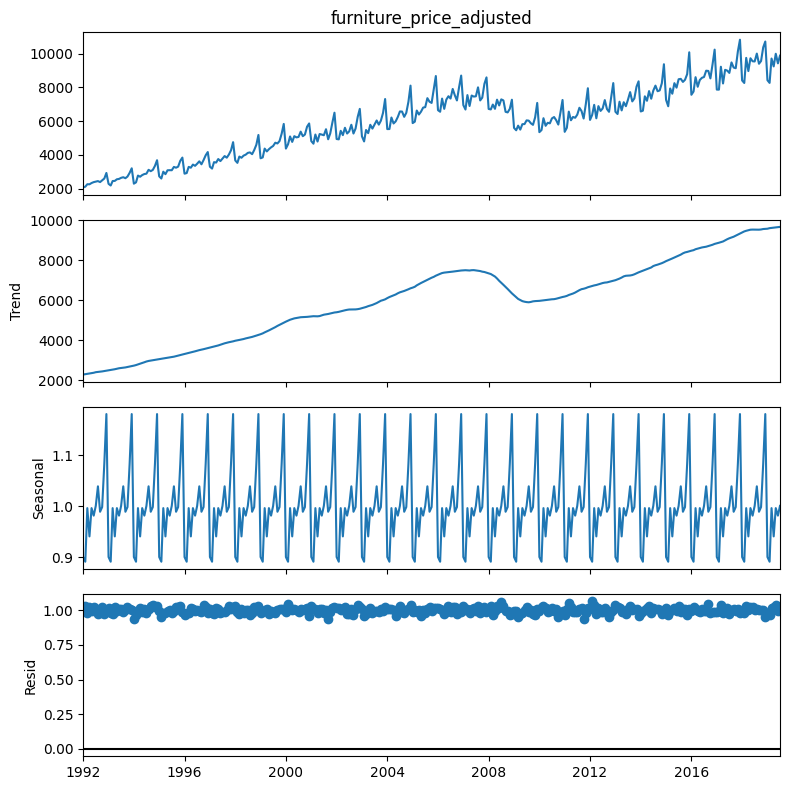

In [20]:
result_mul.plot();

## 8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional

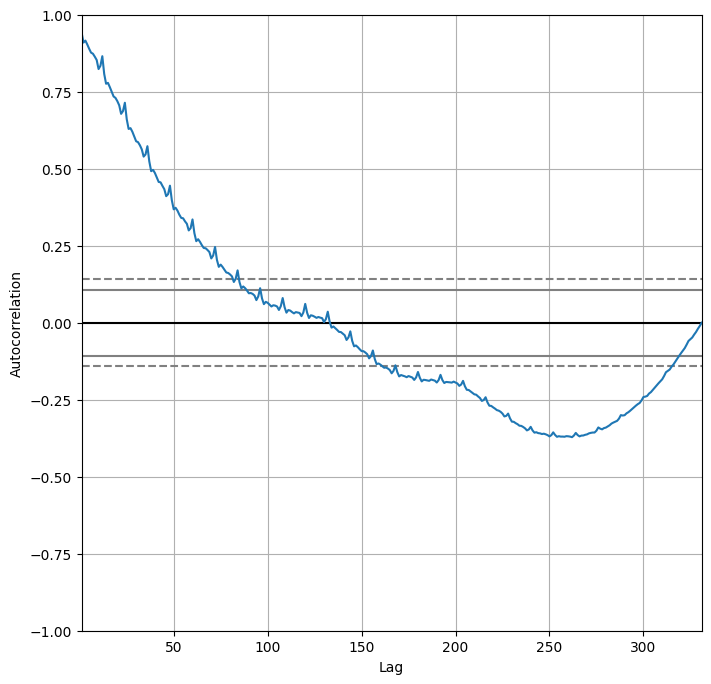

In [21]:
from pandas.plotting import autocorrelation_plot
show_trend = df[df.columns[0]].values
autocorrelation_plot(show_trend.tolist());

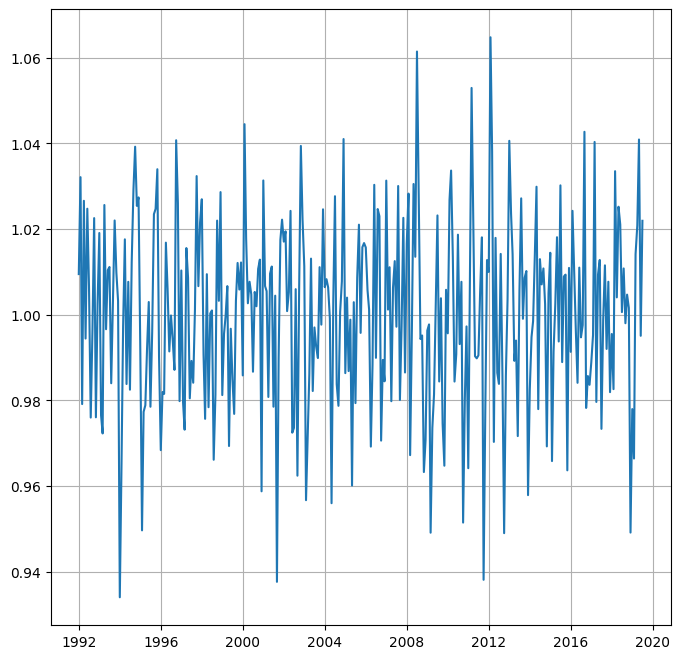

In [22]:
plt.plot(df.index, df[df.columns[0]] / result_mul.trend / result_mul.seasonal)
plt.grid();

In [23]:
# from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(df['furniture_price_adjusted']);

Bien hecho. Pues ahora que dominas esta parte, pasemos con 

9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuéstralo mediante una matriz de correlación.
10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?
11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

## 9. ¿Qué dependencia tiene cada instante de sus últimos 5 lags? Demuéstralo mediante una matriz de correlación.

In [24]:
df = pd.read_csv("data/df_furniture.csv")

df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index(['Month'])

# Nos creamos los lags:
df['lag1'] = df['furniture_price_adjusted'].shift(1)
df['lag2'] = df['furniture_price_adjusted'].shift(2)
df['lag3'] = df['furniture_price_adjusted'].shift(3)
df['lag4'] = df['furniture_price_adjusted'].shift(4)
df['lag5'] = df['furniture_price_adjusted'].shift(5)
df = df.dropna()
df

,furniture_price_adjusted,lag1,lag2,lag3,lag4,lag5
Month,,,,,,
1992-06-01,2384.638567,2331.414618,2255.103236,2260.570891,2114.485812,2073.432724
1992-07-01,2417.165376,2384.638567,2331.414618,2255.103236,2260.570891,2114.485812
1992-08-01,2445.498729,2417.165376,2384.638567,2331.414618,2255.103236,2260.570891
1992-09-01,2387.351705,2445.498729,2417.165376,2384.638567,2331.414618,2255.103236
1992-10-01,2489.350838,2387.351705,2445.498729,2417.165376,2384.638567,2331.414618
...,...,...,...,...,...,...
2019-03-01,9718.107698,8271.237355,8431.965334,10726.595075,10380.194097,9569.037851
2019-04-01,9248.814254,9718.107698,8271.237355,8431.965334,10726.595075,10380.194097
2019-05-01,10001.305304,9248.814254,9718.107698,8271.237355,8431.965334,10726.595075


<AxesSubplot: xlabel='Month'>

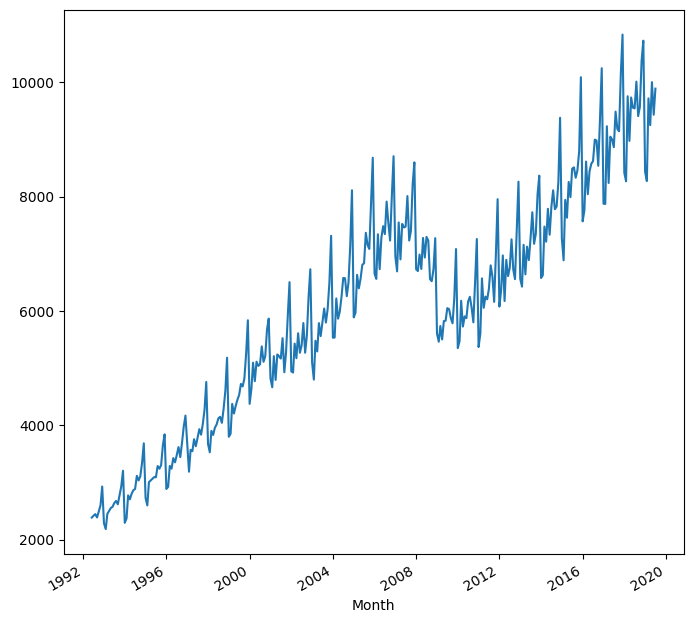

In [25]:
df['furniture_price_adjusted'].plot()

In [26]:
df.corr()

,furniture_price_adjusted,lag1,lag2,lag3,lag4,lag5
furniture_price_adjusted,1.000000,0.948959,0.926114,0.943894,0.940005,0.935901
lag1,0.948959,1.000000,0.949044,0.926023,0.944058,0.939980
lag2,0.926114,0.949044,1.000000,0.949169,0.926191,0.944155
lag3,0.943894,0.926023,0.949169,1.000000,0.949385,0.926156
lag4,0.940005,0.944058,0.926191,0.949385,1.000000,0.949554
lag5,0.935901,0.939980,0.944155,0.926156,0.949554,1.000000


## 10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

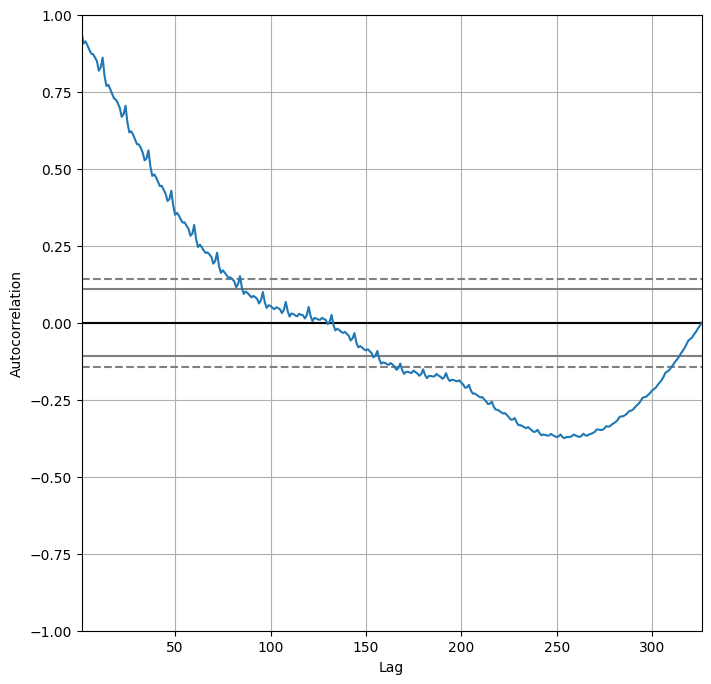

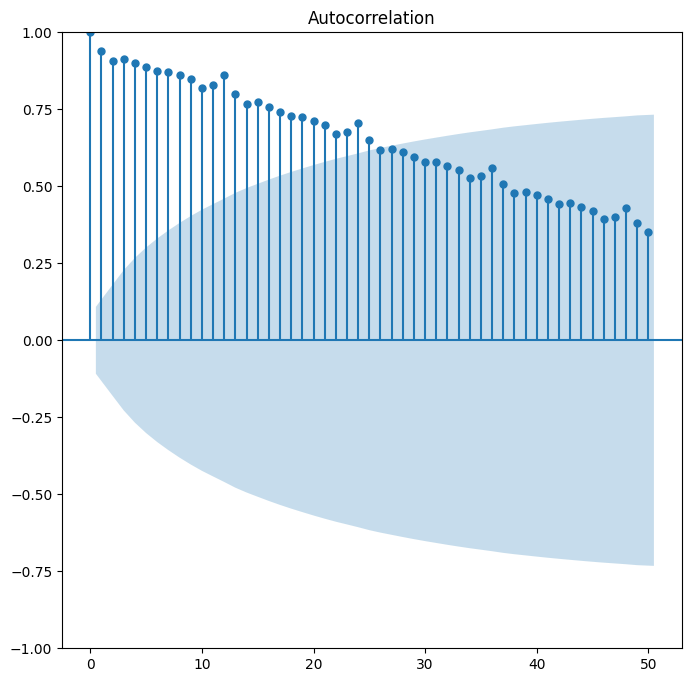

In [27]:
from statsmodels.graphics.tsaplots import plot_acf

autocorrelation_plot(df['furniture_price_adjusted']);
plot_acf(df['furniture_price_adjusted'], lags=50);

In [28]:
df.shape

(326, 6)

## 11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

<AxesSubplot: xlabel='Month'>

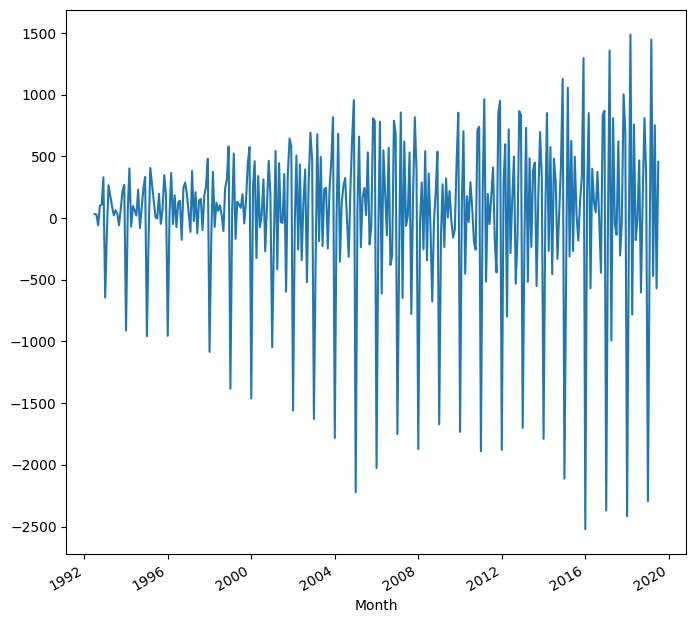

In [29]:
df['furniture_price_adjusted'].diff().dropna().plot()

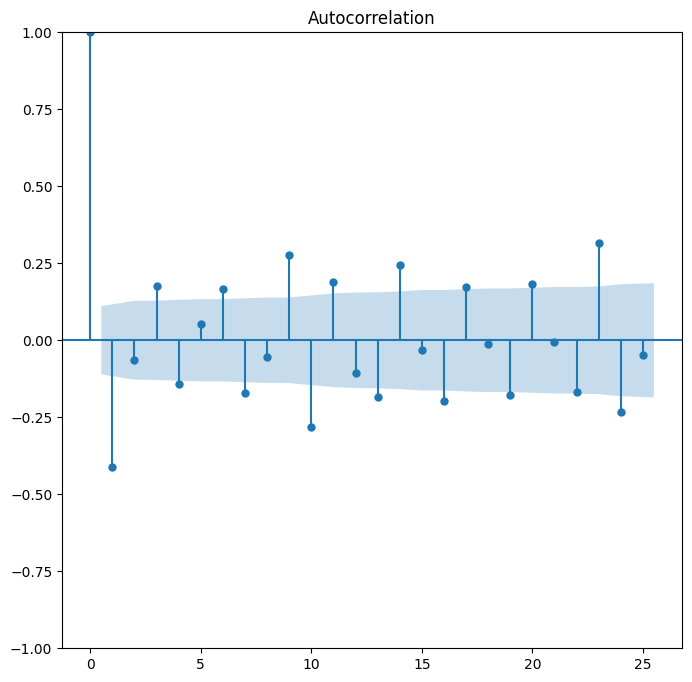

In [30]:
plot_acf(df['furniture_price_adjusted'].diff().diff(12).dropna());